We have covered a lot of statistical models for time series forecasting. Back in chapters 4 and 5, you learned how to model moving average processes and autoregressive processes. We then combined these models to form the ARMA model and added a parameter to forecast non-stationary time series, leading us to the ARIMA model. We then added a seasonal component with the SARIMA model. Adding the effect of exogenous variables culminated in the SARIMAX model. Finally, we covered multivariate time series forecasting using the VAR model. Thus, you now have access to many statistical models that allow you to forecast a wide variety of time series, from simple to more complex. This is a good time to consolidate your learning and put your knowledge into practice with a capstone project.

The objective of the project in this chapter is forecasting the number of antidiabetic drug prescriptions in Australia, from 1991 to 2008. In a professional setting, solving this problem would allow us to gauge the production of antidiabetic drugs, such as to produce enough to meet the demand and but also avoid overproduction. The data we’ll use was recorded by the Australian Health Insurance Commission.

1. The objective is to forecast 12 months of antidiabetic drug prescriptions. Use the last 36 months of the dataset as a test set to allow for rolling forecasts.
2. Visualize the time series.
3. Use time series decomposition to extract the trend and seasonal components.
4. Based on your exploration, determine the most suitable model.
5. Model the series with the usual steps:
    1. Apply transformations to make it stationary
    2. Set the values of d and D. Set the value of m.
    3. Find the optimal (p,d,q)(P,D,Q)m parameters.
    4. Perform residual analysis to validate your model.
6. Perform rolling forecasts of 12 months on the test set.
7. Visualize your forecasts.
8. Compare the model’s performance to a baseline. Select an appropriate baseline and error metric.
9. Conclude whether the model should be used or not.

## 11.1 Importing the required libraries and loading the data
The natural first step is to import the libraries that will be needed to complete the project. We can then load the data and store it in a DataFrame to be used throughout the project.

Thus, we’ll import the following libraries and specify the magic function %matplotlib inline to display the plots in the notebook:

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
df = pd.read_csv('./AusAntidiabeticDrug.csv')
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


## 11.2 Visualize time series

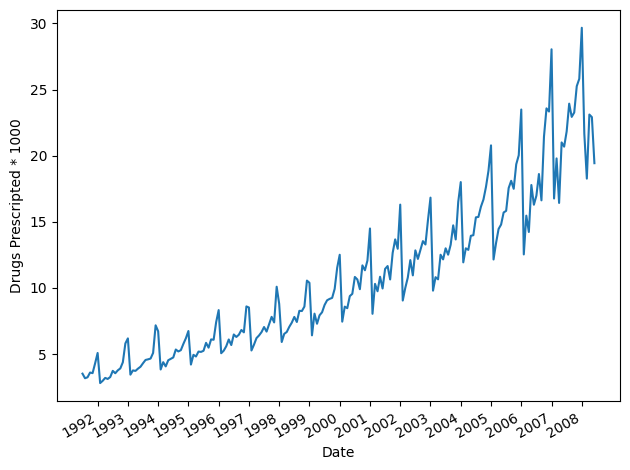

In [9]:
fig, ax = plt.subplots()

ax.plot(df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Drugs Prescripted * 1000')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

## 11.3 Use time series decomposition to extract the trend and seasonal components.

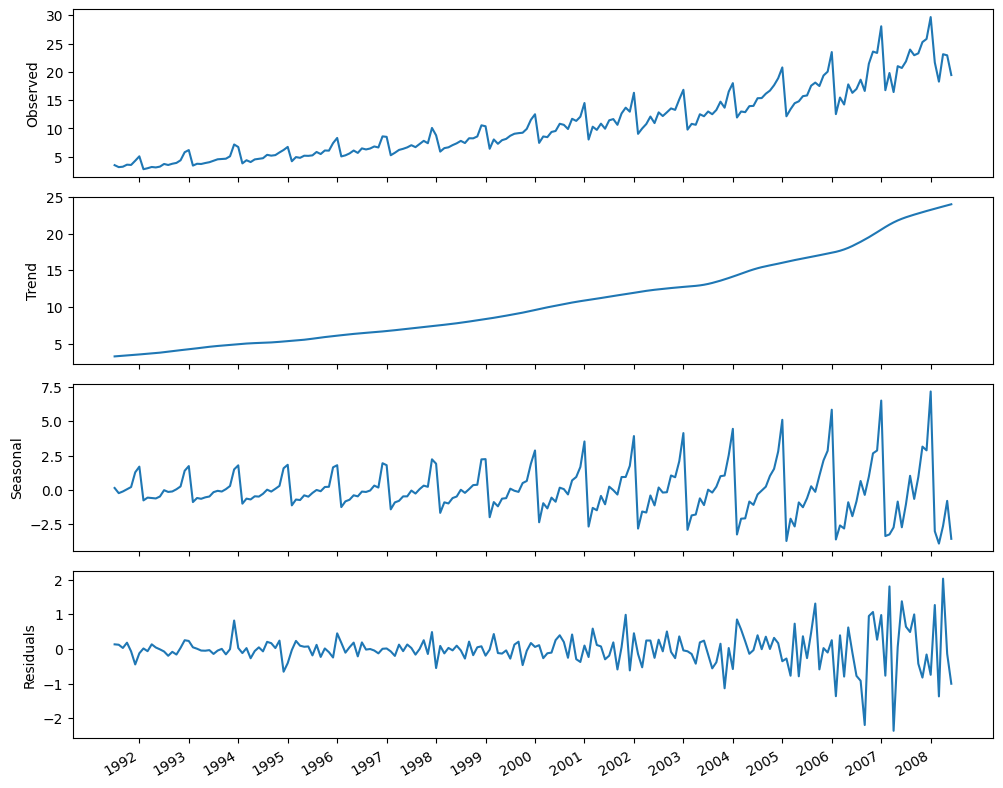

In [10]:
decomposition = STL(df['y'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

## 11.4 Based on your exploration, determine the most suitable model.

Use of SARIMA Model

## 11.5 Model the series with the usual steps:

### 11.5.1 Apply transformations to make it stationary

In [11]:
ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.1451856893067363
p-value: 1.0


In [12]:
df_diff = np.diff(df['y'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474497512
p-value: 0.11665341686468494


In [15]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.78525490460222
p-value: 0.0


### 11.5.2 Set the values of d and D. Set the value of m.

d = 1

D = 1

m = 12

### 11.5.3 Find the optimal (p,d,q)(P,D,Q)m parameters.

In [17]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['y'][:-36]

d = 1
D = 1
m = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, m)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 3)",17.957727
1,"(3, 1, 1, 3)",270.951096
2,"(3, 3, 1, 3)",271.368963
3,"(3, 2, 1, 3)",272.222636
4,"(3, 3, 0, 1)",272.580415
...,...,...
251,"(0, 0, 3, 1)",351.425175
252,"(0, 0, 1, 1)",351.466837
253,"(0, 0, 0, 1)",354.751719
254,"(0, 0, 1, 0)",357.173706


**Optimal Parameters**:

*(p,d,q)* = (1,1,0)

*(P,D,Q)* = (2,1,3)

*m* = 12

### 11.5.4 Perform residual analysis to validate your model.

In [20]:
print(len(train))

168


In [22]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Tue, 27 Sep 2022   AIC                            270.951
Time:                                            19:40:13   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

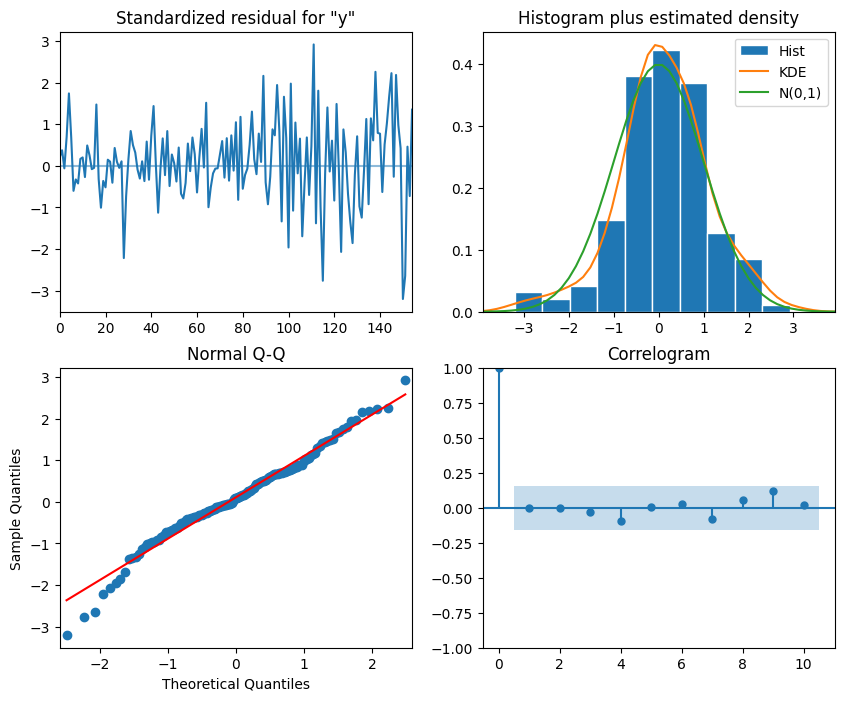

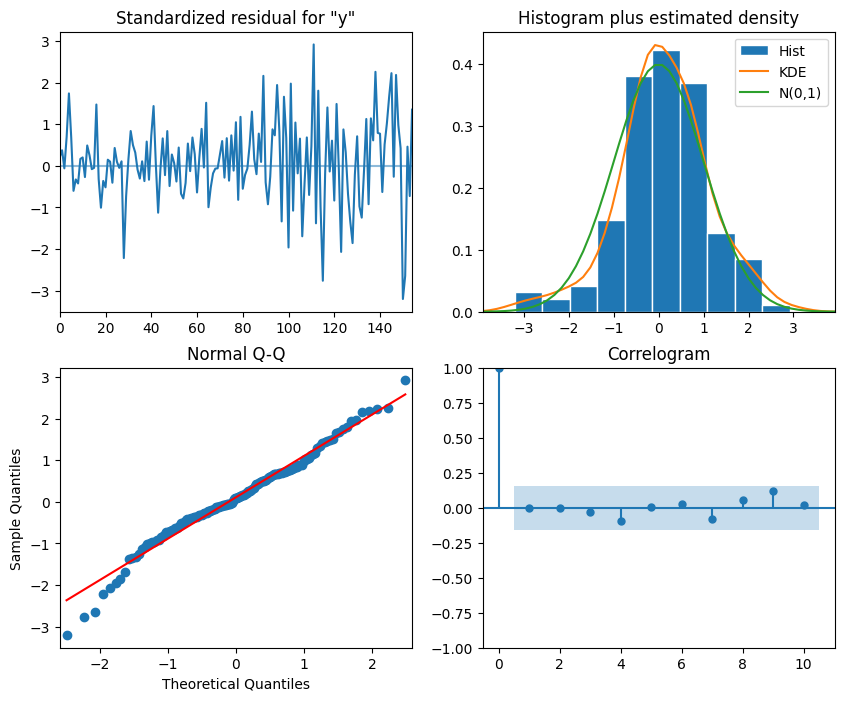

In [24]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [25]:
residuals = SARIMA_model_fit.resid

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

      lb_stat  lb_pvalue
1    0.436855   0.508644
2    0.627622   0.730657
3    0.646117   0.885798
4    2.258461   0.688342
5    2.950656   0.707593
6    3.389633   0.758591
7    9.982299   0.189579
8   10.592276   0.225888
9   11.854422   0.221641
10  11.985724   0.286013


## 11.6 Perform rolling forecasts of 12 months on the test set.

In [40]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [42]:
pred_df = df[168:]

TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.748854
169,2005-08-01,17.554701,15.370764,16.684325
170,2005-09-01,18.100864,16.142005,17.188516
171,2005-10-01,17.496668,16.685754,18.087193
172,2005-11-01,19.347265,17.636728,18.657697
173,2005-12-01,20.031291,18.869325,19.946689
174,2006-01-01,23.486694,20.778723,22.074403
175,2006-02-01,12.536987,12.154552,13.744332
176,2006-03-01,15.467018,13.402392,15.085371
177,2006-04-01,14.233539,14.459239,15.654638


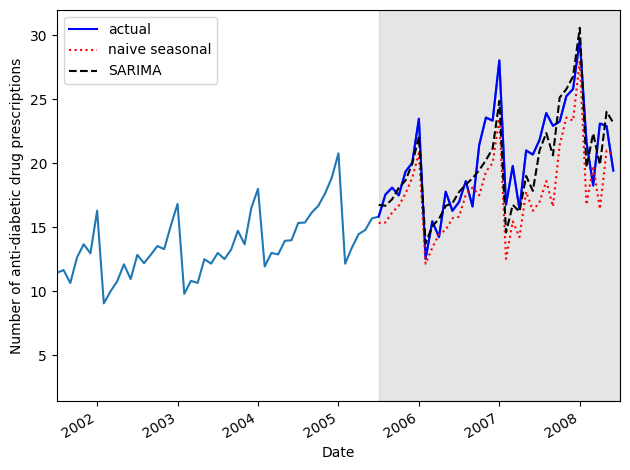

In [45]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

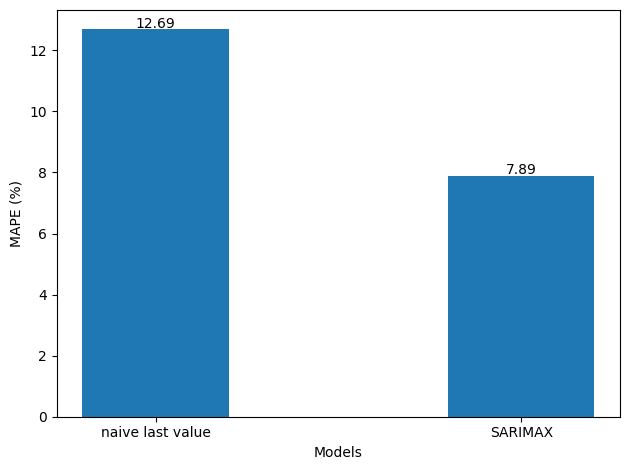

In [46]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_last = mape(pred_df.y, pred_df.last_season)
mape_SARIMAX = mape(pred_df.y, pred_df.SARIMA)

fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
plt.tight_layout()